In [1]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200
cell_line="HEK293"
regions="enhancers"

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    regions = regions,
    window_size = window_size
)

y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

#X = X.values
shape=(200,4)
#type(X)
# Here one should feature selection. How can we do this?

In [2]:
from ucsc_genomes_downloader import Genome
assembly=r"C:\Users\matte\Desktop\Bioinformatica\genomes\hg19"
genome = Genome(assembly)

In [3]:
import tensorflow as tf
tf.__version__

C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\matte\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

'1.14.0'

In [4]:
import pandas as pd
import numpy as np
from keras_bed_sequence import BedSequence

def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]


def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

In [5]:
#sequences =  to_dataframe(
 #       flat_one_hot_encode(genome, X, window_size),
  #      window_size
  #  )


In [6]:
sequences=to_bed(X)
sequences

,chrom,chromStart,chromEnd,strand
0,chr1,839687,839887,.
1,chr1,840711,840911,.
2,chr1,845481,845681,.
3,chr1,855755,855955,.
4,chr1,856613,856813,.
...,...,...,...,...
65418,chrY,58986666,58986866,.
65419,chrY,58994460,58994660,.
65420,chrY,59019261,59019461,.
65421,chrY,59019818,59020018,.


In [7]:
from typing import Dict, Tuple, List

class Model:
    def __init__(self, name: str, model, **kwargs):
        self.name = name
        self.model = model
        self.kwargs = kwargs
        
    def __str__(self) -> str:
        return self.name
    
    def __repr__(self) -> str:
        return self.name
    
    def get_model(self) -> Tuple:
        return (self.model, self.kwargs)

In [8]:
from sklearn.tree import DecisionTreeClassifier

def get_decision_tree(name: str = 'DecisionTree', criterion: str = 'gini', max_depth: int = 50, 
                      random_state: int = 42, class_weight: str = 'balanced', **kwargs) -> Model:
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        random_state=random_state,
        class_weight=class_weight
    )
    return Model(name, model, **kwargs)

Model.DecisionTree = get_decision_tree

In [9]:
Model.DecisionTree()

DecisionTree

In [10]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count


def get_random_forest(name: str = 'RandomForest', n_estimators: int = 500, criterion: str = 'gini', 
                      max_depth: int = 30, random_state: int = 42, 
                      class_weight: str = 'balanced', n_jobs: int = cpu_count, **kwargs):
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        random_state=random_state,
        class_weight=class_weight,
        n_jobs=n_jobs
    )
    return Model(name, model, **kwargs)

Model.RandomForest = get_random_forest

In [11]:
Model.RandomForest()

RandomForest

In [12]:
from tensorflow.keras.layers import Layer, Input, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import StratifiedShuffleSplit


In [13]:
from tensorflow.keras.layers import AlphaDropout, ThresholdedReLU

In [14]:
from tensorflow.keras.layers import MaxPool2D,MaxPool1D

In [15]:
from tensorflow.keras.models import Sequential

def get_sequential(default_name: str = 'Sequential'):
    # no first and last layer
    def get_layers(*layers: Tuple[Layer]):
        def get_model(input_shape: Tuple[int], name: str = None, optimizer: str = 'nadam', 
                      loss: str = 'binary_crossentropy', metrics: List = None,
                      epochs: int = 1000, batch_size: int = 1024, 
                      validation_split: float = 0.1, shuffle: bool = True, verbose: bool = False, 
                      callbacks: List = None, **kwargs):
            name = name or default_name
            input_layer = Input(shape=input_shape)
            output_layer = Dense(1, activation="sigmoid")
            model = Sequential((input_layer,) + layers + (output_layer,), name)
            
            metrics = metrics or [
                "accuracy",
                AUC(curve="ROC", name="auroc"),
                AUC(curve="PR", name="auprc")
            ]
            model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics
            )
            
            kwargs.update({
                'epochs': epochs,
                'batch_size': batch_size,
                'validation_split': validation_split,
                'shuffle': shuffle,
                'verbose': verbose,
                'callbacks': callbacks
            })
            model.summary()
            return Model(name, model, **kwargs)
        return get_model
    return get_layers

Model.Sequential = get_sequential()

In [16]:
Model.Sequential()((104,20))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104, 1)            21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


Sequential

In [17]:
Model.Perceptron = get_sequential('Perceptron')()

In [18]:
Model.Perceptron((104,))

Model: "Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 105       
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Perceptron

In [19]:
Model.MLP = get_sequential('MLP') 
Model.FFNN = get_sequential('FFNN')
Model.CNN = get_sequential('CNN')

In [20]:
#training 20 sec 
Model.MLP_Epi = Model.MLP(
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
)

In [21]:
#training 40 sec
Model.FFNN_Epi = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [22]:
#test con Alphadropout e ThresholdedReLU
Model.FFNN_Epi_2 = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    ThresholdedReLU(0.05),
    Dense(64, activation="relu"),
    AlphaDropout(0.3), #new
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [23]:
#test con
Model.FFNN_Epi_3 = Model.FFNN(
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    BatchNormalization(),
    ThresholdedReLU(0.05),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    AlphaDropout(0.5), #new
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [24]:
Model.MLP_Seq = Model.MLP(
    Flatten(),
    Dense(64, activation="relu"),
    Dense(32, activation="relu")
)

In [25]:
Model.FFNN_Seq = Model.FFNN(
    Flatten(),
    Dense(256, activation="relu"),
    Dense(128),
    BatchNormalization(),
    ThresholdedReLU(0.05),
    Dense(64, activation="relu"),
    AlphaDropout(0.3), #new
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
)

In [26]:
Model.CNN_Seq = Model.CNN(
    Reshape((200, 4, 1)),
    Conv2D(64, kernel_size=(10, 2), activation="relu"),
    BatchNormalization(),
    Conv2D(64, kernel_size=(5, 2), activation="relu"),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32, kernel_size=(10, 1), activation="relu"),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(32, activation="relu"),
    Dropout(0.3),


)

In [27]:

from typing import Dict, Union, Tuple

import tensorflow as tf

from tensorflow.keras.utils import Sequence

import numpy as np

from tensorflow.keras.utils import Sequence

import numpy as np




from typing import List







def sequence_length(sequence: List, batch_size: int) -> int:

    """Return number of batch sizes contained in sequence.



    Parameters

    -----------

    sequence: List,

        Iterable to split into batches.

    batch_size: int,

        Size of the batches.



    Returns

    -----------

    Return number of batch size contained in given sequence, by excess.

    """

    return int(np.ceil(len(sequence) / float(batch_size)))

def batch_slice(index: int, batch_size: int) -> slice:

    """Return slice corresponding to given index for given batch_size.



    Parameters

    ---------------

    index: int,

        Index corresponding to batch to be rendered.

    batch_size: int

        Batch size for the current Sequence.



    Returns

    ---------------

    Return slice corresponding to given index for given batch_size.

    """

    return slice(index * batch_size, (index + 1) * batch_size)


class NumpySequence(Sequence):

    """NumpySequence is a Sequence wrapper to uniform Numpy Arrays as Keras Sequences.



    Usage Examples

    ----------------------------

    The main usage of this class is as a package private wrapper for Sequences.

    It is required to uniformely return a batch of the array,

    without introducing special cases.

    However, a basic usage example could be the following:



    Wrapping a numpy array as a Sequence

    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



    .. code:: python



        from keras_mixed_sequence import NumpySequence

        import numpy as np



        examples_number = 1000

        features_number = 10

        batch_size = 32



        my_array = np.random.randint(

            2, shape=(

                examples_number,

                features_number

            )

        )



        my_sequence = NumpySequence(my_array, batch_size)



        # Keras will require the i-th batch as follows:

        ith_batch = my_sequence[i]



    """



    def __init__(

        self,

        array: np.ndarray,

        batch_size: int,

        seed: int = 42,

        elapsed_epochs: int = 0,

        dtype = float

    ):

        """Return new NumpySequence object.



        Parameters

        --------------

        array: np.ndarray,

            Numpy array to be split into batches.

        batch_size: int,

            Batch size for the current Sequence.

        seed: int = 42,

            Starting seed to use if shuffling the dataset.

        elapsed_epochs: int = 0,

            Number of elapsed epochs to init state of generator.

        dtype = float,

            Type to which to cast the array if it is not already.



        Returns

        --------------

        Return new NumpySequence object.

        """

        if array.dtype != dtype:

            array = array.astype(dtype)

        self._array, self._batch_size = array, batch_size

        self._seed, self._elapsed_epochs = seed, elapsed_epochs



    def on_epoch_end(self):

        """Shuffle private numpy array on every epoch end."""

        state = np.random.RandomState(seed=self._seed + self._elapsed_epochs)

        self._elapsed_epochs += 1

        state.shuffle(self._array)



    def __len__(self) -> int:

        """Return length of Sequence."""

        return sequence_length(

            self._array,

            self._batch_size

        )



    def __getitem__(self, idx: int) -> np.ndarray:

        """Return batch corresponding to given index.



        Parameters

        ---------------

        idx: int,

            Index corresponding to batch to be rendered.



        Returns

        ---------------

        Return numpy array corresponding to given batch index.

        """

        return self._array[batch_slice(idx, self._batch_size)]




class MixedSequence(Sequence):

    """Handles Mixed type input / output Sequences.



    Usage examples

    -----------------------------

    """



    def __init__(

        self,

        x: Union[Dict[str, Union[np.ndarray, Sequence]], np.ndarray, Sequence],

        y: Union[Dict[str, Union[np.ndarray, Sequence]], np.ndarray, Sequence],

        batch_size: int

    ):

     

        # Casting to dictionary if not one already

        x, y = [

            e if isinstance(e, Dict) else {0: e}

            for e in (x, y)

        ]



        # Retrieving sequence length

        self._sequence_length = None

        self._batch_size = batch_size

        for candidate in (*x.values(), *y.values()):

            if isinstance(candidate, Sequence):

                self._sequence_length = len(candidate)

                break



        # Veryfing that at least a sequence was provided

        if self._sequence_length is None:

            raise ValueError("No Sequence was provided.")



        # Converting numpy arrays to Numpy Sequences

        x, y = [

            {

                key: NumpySequence(candidate, batch_size) if isinstance(

                    candidate, np.ndarray) else candidate

                for key, candidate in dictionary.items()

            }

            for dictionary in (x, y)

        ]



        # Checking that every value within the dictionaries

        # is now a sequence with the same length.

        for dictionary in (x, y):

            for _, value in dictionary.items():

                if len(self) != len(value):

                    raise ValueError(

                        "One or given sub-Sequence does not match length of other Sequences."

                    )



        self._x, self._y = x, y



    def on_epoch_end(self):

        """Call on_epoch_end callback on every sub-sequence."""

        for dictionary in (self._x, self._y):

            for _, value in dictionary.items():

                value.on_epoch_end()



    def __len__(self) -> int:

        """Return length of Sequence."""

        return self._sequence_length



    @property

    def steps_per_epoch(self) -> int:

        """Return length of Sequence."""

        return len(self)



    def __getitem__(self, idx: int) -> Tuple[

        Union[np.ndarray, Dict],

        Union[np.ndarray, Dict]

    ]:

        """Return batch corresponding to given index.



        Parameters

        ---------------

        idx: int,

            Index corresponding to batch to be rendered.



        Returns

        ---------------

        Return Tuple containing input and output batches.

        """

        return tuple([

            {

                key: sequence[idx]

                for key, sequence in dictionary.items()

            } if len(dictionary) > 1 else next(iter(dictionary.values()))[idx]

            for dictionary in [

                self._x,

                self._y

            ]

        ] + (

            []

            if tf.__version__.startswith("1.14.0")

            else

            [{key: None for key in self._y}]

        ))

In [28]:
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
#from keras_mixed_sequence import MixedSequence
from tensorflow.keras.utils import Sequence


def get_holdout(train:np.ndarray, test:np.ndarray, bed:pd.DataFrame, labels:np.ndarray, genome:genome, batch_size=1024)->Tuple[Sequence, Sequence]:
    return (
        MixedSequence(
            x=BedSequence(genome, bed.iloc[train], batch_size=batch_size),
            y=labels[train],
            batch_size=batch_size
        ),
        MixedSequence(
            x= BedSequence(genome, bed.iloc[test], batch_size=batch_size),
            y=labels[test],
            batch_size=batch_size #batch_size maggiori, risultati + veloci
        )
    )

In [29]:
## from sklearn.model_selection import StratifiedShuffleSplit

splits = 10 #da testare un numero diverso di split
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)


In [30]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels
import numpy as np

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

#si usano solo per categorizzazione, non hanno senso per regressione
# auroc: area sotto la curva di Receiver operating characteristic: analizza falsi positivi e negativi
# valore minimo è 0.5 (non impara niente)  valore massimo è 1 (modello perfetto)
# auprc: area sotto la curva di precision recall: va a computare per diversi treashold di precisioni diversi, la somma delle aree
#sottese sotto i diversi traingolini della precision-reacall. Un modello che non impara nulla ha AUPRC = 0 e un modello perfetto ha
# AUPRC = 1

In [31]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [32]:
models=[]


models.append(Model.MLP_Seq(shape,name="MLP"))
models.append(Model.FFNN_Seq(shape,name="FFNN"))
models.append(Model.CNN_Seq(shape,name="CNN"))

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                51264     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 53,377
Trainable params: 53,377
Non-trainable params: 0
_________________________________________________________________
Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 800)               0         
_____________________________________________

In [33]:
from tqdm.auto import tqdm
import pandas as pd

In [1]:
import json
import compress_json
import os
if os.path.exists(r"C:/Users/matte/Documents/GitHub/bioinformatica/code/results_HEK293_enhancers_seq.json"):
    with open(r"C:/Users/matte/Documents/GitHub/bioinformatica/code/results_HEK293_enhancers_seq.json") as json_file:
        results = json.load(json_file)
else:
    results = []
    
    for i, (train_index, test_index) in tqdm(enumerate(holdouts.split(sequences, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
        train, test = get_holdout(train_index, test_index, sequences, y, genome)
        for model in tqdm(models, total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
            if precomputed(results, model.name, i):
                continue
            history = model.model.fit(
                train,
                steps_per_epoch=train.steps_per_epoch,
                validation_data=test,
                validation_steps=test.steps_per_epoch,
                epochs=100,
                shuffle=True,
                verbose=False,
                callbacks=[
                    EarlyStopping(monitor="val_loss", mode="min", patience=50),
                ]
            ).history
            scores = pd.DataFrame(history).iloc[-1].to_dict()
            results.append({
                "model":model.name,
                "run_type":"train",
                "holdout":i,
                **{
                    key:value
                    for key, value in scores.items()
                    if not key.startswith("val_")
                }
            })
            results.append({
                "model":model.name,
                "run_type":"test",
                "holdout":i,
                **{
                    key[4:]:value
                    for key, value in scores.items()
                    if key.startswith("val_")
                }
            })
            compress_json.local_dump(results,  f"results_{cell_line}_{regions}.json")

In [5]:
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])
df


,model,run_type,loss,acc,auroc,auprc
0,MLP,train,0.334857,0.893729,0.580458,0.138265
1,MLP,test,0.343922,0.893771,0.504586,0.108060
2,FFNN,train,0.006235,0.997975,0.999540,0.998281
3,FFNN,test,2.347255,0.844784,0.502107,0.108964
4,CNN_1,train,0.060171,0.977149,0.992145,0.957551
...,...,...,...,...,...,...
295,MLP,test,0.343138,0.893771,0.505827,0.112553
296,FFNN,train,0.336526,0.894322,0.507114,0.117764
297,FFNN,test,0.344810,0.892702,0.497229,0.104853
298,CNN_1,train,0.338681,0.893729,0.497488,0.105710


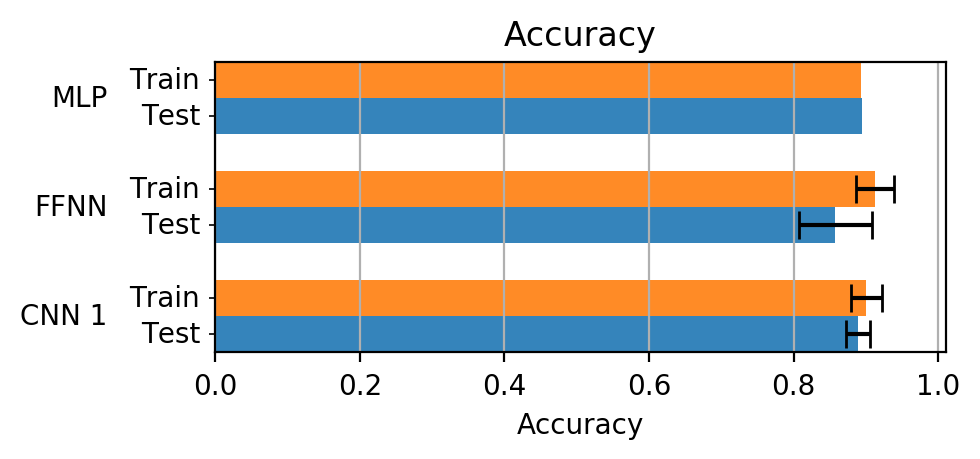

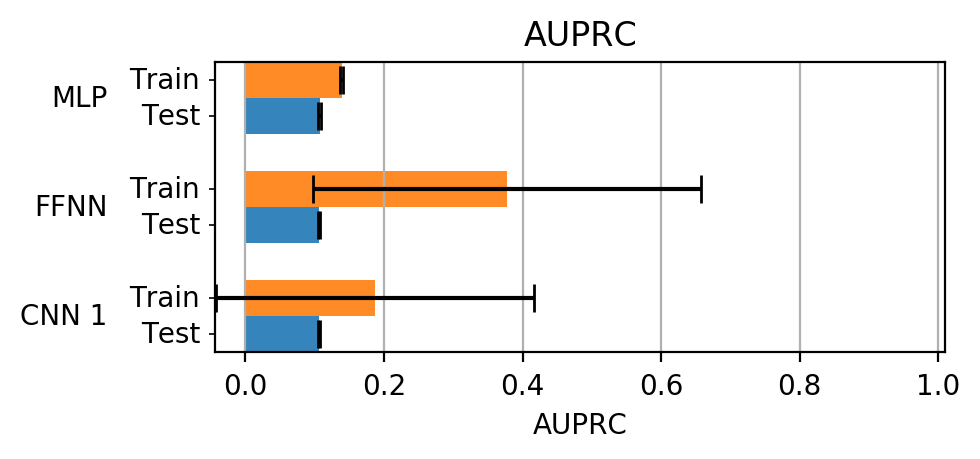

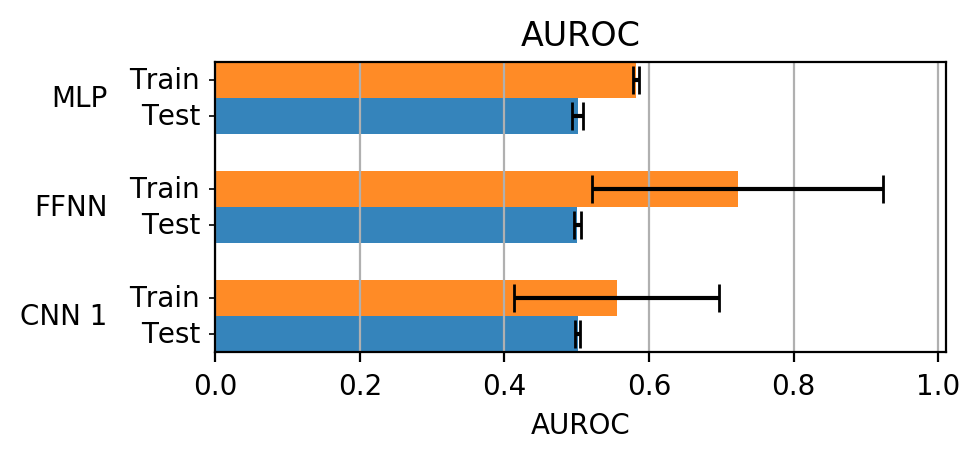

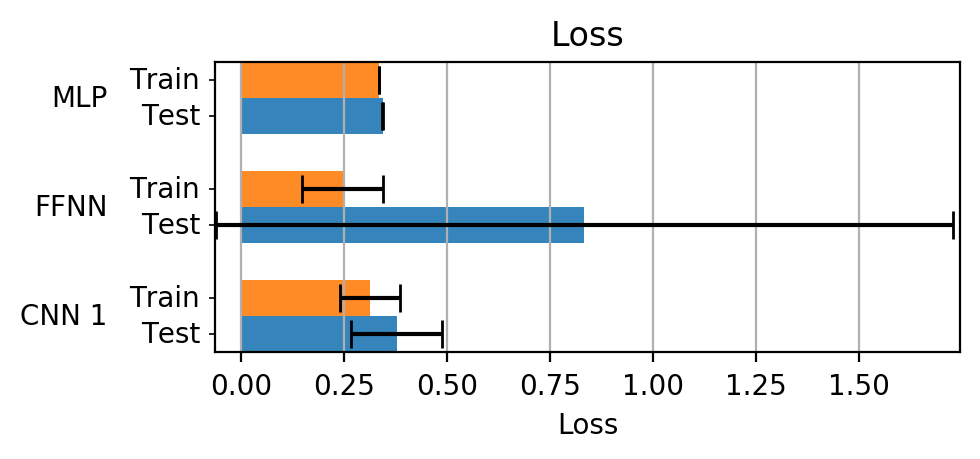

In [10]:
from barplots import barplots
import pandas as pd
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])
df[:5]


barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal",
    verbose=True,
    show_standard_deviation = True,
)

from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

In [7]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
models = df[
    (df.run_type == "test")
]

mlp_scores = models[models.model=="MLP"]
FFNN_scores = models[models.model=="FFNN"]
CNN_scores = models[models.model=="CNN"]

alpha = 0.01

for metric in mlp_scores.columns[-4:]:
    print(metric)
    a,  b = mlp_scores[metric], FFNN_scores[metric]
    stats, p_value = wilcoxon(a, b)
    if p_value > alpha:
        print(p_value, "The two models performance are statistically identical.")
    else:
        print(p_value, "The two models performance are different")
        if a.mean() > b.mean():
            print("The first model is better")
        else:
            print("The second model is better")

loss
7.666395813806118e-06 The two models performance are different
The second model is better
acc
7.539859267508618e-10 The two models performance are different
The first model is better
auroc
0.3616451100155419 The two models performance are statistically identical.
auprc
0.5527284110902966 The two models performance are statistically identical.
